In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import boto3
from botocore.client import Config
import os
import pandas as pd
from io import StringIO
import matplotlib.dates as dates
from datetime import datetime
import matplotlib.ticker as ticker
from random import shuffle
from time import time
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler

os.chdir('C:\\Users\\A Sua\\Documents\\AWS\\credentials')
list_of_lines = []
with open('capstoner_key.txt') as fp:
    lines = fp.readlines()
    for line in lines:
        line = line.strip()
        list_of_lines.append(line)
    fp.close()


location = list_of_lines[0].split('=')[1]
AWS_ACCESS_KEY_ID = list_of_lines[1].split('=')[1]
AWS_SECRET_ACCESS_KEY = list_of_lines[2].split('=')[1]
os.chdir('C:\\Users\\A Sua\\Documents\\FIU\\CAP2020')
%matplotlib notebook

In [3]:
%matplotlib notebook
register_matplotlib_converters()

In [4]:
df_name_list = ['df_returns', 'df_price', 'df_spread', 'df_volume', 'df_shares_out', 'df_askhi']

In [5]:
df_list = []
for df_name in df_name_list:
    ### BUCKETS & KEYS
    BUCKET_NAME = 'capstonefiu2020-data'
    key_location = 'data/processed'
    file_name = '{}07_18.csv'.format(df_name)
    key_path = key_location + '/' + file_name

    ### ACTIVATE CLIENT
    client = boto3.client('s3', 
                  aws_access_key_id = AWS_ACCESS_KEY_ID,
                   aws_secret_access_key=AWS_SECRET_ACCESS_KEY)


    ### INSTANTIATE DATAFRAME
    csv_obj = client.get_object(Bucket = BUCKET_NAME, Key=key_path)
    body = csv_obj['Body']
    csv_string = body.read().decode('utf-8')

    df = pd.read_csv(StringIO(csv_string))
    df.index = df['Unnamed: 0']
    df = df.drop('Unnamed: 0', axis=1)
    df.index.names = ['date']


    #df_bidlo.head()
    #### TRANSPOSE DATA FOR EASE OF USE
    df = df.T
    df.index = pd.to_datetime(df.index)
    df_list.append(df)
    print('{} has shape: {}'.format(df_name, df.shape))

df_returns has shape: (3020, 388)
df_price has shape: (3020, 388)
df_spread has shape: (3020, 388)
df_volume has shape: (3020, 388)
df_shares_out has shape: (3020, 388)
df_askhi has shape: (3020, 388)


In [6]:
df_returns = df_list[0]
df_price = abs(df_list[1])
df_spread = df_list[2]
df_volume = df_list[3]
df_sharesout = df_list[4]
df_askhi = df_list[5]

df_price_askhi = df_price/df_askhi
df_volume_sharesout = df_volume/df_sharesout

In [7]:
range_series= df_price.apply(max, axis=0) - df_price.apply(min, axis=0) 

In [12]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

### Define Functions

In [8]:
def y_fmt(y, pos):
    decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9 ]
    suffix  = ["G", "M", "k", "" , "m" , "u", "n"  ]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    #print (val, signf)
                    if str(val).split(".")[1] == "0":
                       return '{val:d}{suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])

                #return y
    return y

### Generate Dates

### Find the dates of the worst trading days systemically & by the company

In [9]:
dates = df_price.index
df_returns.columns[:5]

Index(['ORCL_ORACLE CORP', 'MSFT_MICROSOFT CORP',
       'TROW_T ROWE PRICE GROUP INC', 'HON_HONEYWELL INTERNATIONAL INC',
       'ADM_ARCHER DANIELS MIDLAND CO'],
      dtype='object', name='date')

#### RETURNS: 5 worst Return dates: DOW JONES, S&P

In [10]:
worst_dates_sp = pd.to_datetime(['2008-10-15', '2008-09-29', '2008-12-01', '2008-10-09', '2008-11-20'])
worst_dates_sp

DatetimeIndex(['2008-10-15', '2008-09-29', '2008-12-01', '2008-10-09',
               '2008-11-20'],
              dtype='datetime64[ns]', freq=None)

## RETURNS

### RETURNS: 5 worst Return dates: COMPNAY

In [11]:
worst_days_returns = {}
for symbol in df_returns.columns:
    temp_series = df_returns[symbol].sort_values(ascending=True).iloc[:5]
    worst_days_returns[symbol] = temp_series
worst_days_returns['ORCL_ORACLE CORP']

2011-12-21   -0.116558
2008-10-15   -0.098361
2013-03-21   -0.096882
2018-03-20   -0.094321
2013-06-21   -0.092593
Name: ORCL_ORACLE CORP, dtype: float64

### RETURNS: 5 worst Return dates: S&P

In [12]:
worst_days_returns_sp = {}
for symbol in df_returns.columns:
    temp_series = pd.Series([df_returns[symbol][worst_dates_sp[i]] for i in range(len(worst_dates_sp))], index=[worst_dates_sp])
    worst_days_returns_sp[symbol] = temp_series
worst_days_returns_sp['ORCL_ORACLE CORP']

2008-10-15   -0.098361
2008-09-29   -0.089719
2008-12-01   -0.038533
2008-10-09   -0.039692
2008-11-20   -0.037500
dtype: float64

## PRICE

### Price: 5 worst Return dates: COMPNAY

In [13]:
worst_days_prices = {}
for symbol in df_price:
    temp_dic = worst_days_returns[symbol]
    temp_series = pd.merge(temp_dic, df_price[symbol], left_index=True, right_index=True, copy=False, suffixes=('_x', ''))[symbol]
    worst_days_prices[symbol] = temp_series
#worst_days_prices

### Price: 5 worst Return dates: S&P

In [14]:
worst_days_prices_sp = {}
for symbol in df_price.columns:
    temp_series = pd.Series([df_price[symbol][worst_dates_sp[i]] for i in range(len(worst_dates_sp))], index=[worst_dates_sp])
    worst_days_prices_sp[symbol] = temp_series

worst_days_prices_sp['HON_HONEYWELL INTERNATIONAL INC']

2008-10-15    29.08
2008-09-29    40.37
2008-12-01    25.99
2008-10-09    31.39
2008-11-20    23.67
dtype: float64

## PRICE/(MAX-MIN)

In [15]:
scaled_price_dic = {}
for value in df_returns.columns:
    temp_range = range_series[value]
    temp_series = df_price[value]/temp_range
    scaled_price_dic[value] = temp_series
scaled_price_dic['HON_HONEYWELL INTERNATIONAL INC']

2007-01-03    0.312955
2007-01-04    0.312817
2007-01-05    0.309833
2007-01-08    0.311706
2007-01-09    0.313927
                ...   
2018-12-24    0.866213
2018-12-26    0.899105
2018-12-27    0.912983
2018-12-28    0.907362
2018-12-31    0.916800
Name: HON_HONEYWELL INTERNATIONAL INC, Length: 3020, dtype: float64

<IPython.core.display.Javascript object>


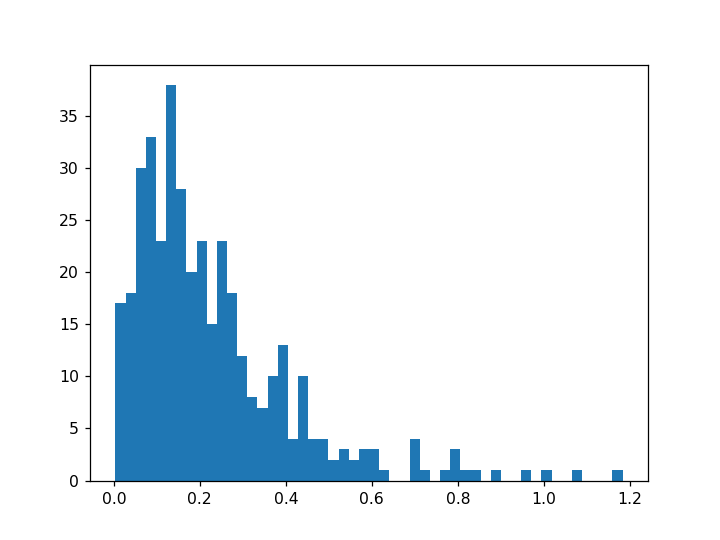

In [23]:
temp_means = []
for value in df_returns.columns:
    temp_means.append(scaled_price_dic[value].min())
plt.hist(temp_means, bins=50)
plt.show()

## SPREAD

### Spread: 5 worst Return dates: COMPNAY

In [16]:
worst_days_spread = {}
for symbol in df_spread:
    temp_dic = worst_days_returns[symbol]
    temp_series = pd.merge(temp_dic, df_spread[symbol], left_index=True, right_index=True, copy=False, suffixes=('_x', ''))[symbol]
    worst_days_spread[symbol] = temp_series
print(len(worst_days_spread))

388


### Spread: 5 worst Return dates: S&P

In [17]:
worst_days_spread_sp = {}
for symbol in df_spread.columns:
    temp_series = pd.Series([df_spread[symbol][worst_dates_sp[i]] for i in range(len(worst_dates_sp))], index=[worst_dates_sp])
    worst_days_spread_sp[symbol] = temp_series

worst_days_spread_sp['HON_HONEYWELL INTERNATIONAL INC']

2008-10-15    3.69
2008-09-29    4.39
2008-12-01    1.87
2008-10-09    5.27
2008-11-20    2.44
dtype: float64

## VOLUME

### Volume: 5 worst Return dates: COMPNAY

In [18]:
worst_days_volume = {}
for symbol in df_volume.columns:
    temp_dic = worst_days_returns[symbol]
    temp_series = pd.merge(temp_dic, df_volume[symbol], left_index=True, right_index=True, copy=False, suffixes=('_x', ''))[symbol]
    worst_days_volume[symbol] = temp_series
print(len(worst_days_volume))

388


### Volume: 5 worst Return dates: S&P

In [19]:
worst_days_volume_sp = {}
for symbol in df_volume.columns:
    temp_series = pd.Series([df_volume[symbol][worst_dates_sp[i]] for i in range(len(worst_dates_sp))], index=[worst_dates_sp])
    worst_days_volume_sp[symbol] = temp_series

worst_days_volume_sp['HON_HONEYWELL INTERNATIONAL INC']

2008-10-15    12289000.0
2008-09-29    10095800.0
2008-12-01     6045100.0
2008-10-09    12508700.0
2008-11-20    10206600.0
dtype: float64

## VOLUME/SHARESOUT

### Volume/Sharesout: 5 worst Return dates: COMPNAY

In [20]:
worst_days_volume_sharesout = {}
for symbol in df_volume_sharesout.columns:
    temp_dic = worst_days_returns[symbol]
    temp_series = pd.merge(temp_dic, df_volume_sharesout[symbol], left_index=True, right_index=True, copy=False, suffixes=('_x', ''))[symbol]
    worst_days_volume_sharesout[symbol] = temp_series
print(len(worst_days_volume_sharesout))

388


### Volume/Sharesout: 5 worst Return dates: S&P

In [21]:
worst_days_volume_sharesout_sp = {}
#error_list = []
for symbol in df_volume_sharesout.columns:
    temp_series = pd.Series([df_volume_sharesout[symbol][worst_dates_sp[i]] for i in range(len(worst_dates_sp))], index=[worst_dates_sp])
    worst_days_volume_sharesout_sp[symbol] = temp_series

worst_days_volume_sharesout_sp['HON_HONEYWELL INTERNATIONAL INC']

2008-10-15    16.507799
2008-09-29    13.561676
2008-12-01     8.323294
2008-10-09    16.802922
2008-11-20    14.053122
dtype: float64

## PRICE/ASKHI

### Dictionary of Positive/Negative Returns for each stock

In [22]:
high_returns = {}
low_returns = {}

for symbol in df_returns.columns:
    temp_series = df_returns[symbol]
    temp_series_high = temp_series[temp_series>0.0]
    temp_series_low = temp_series[temp_series<=-0.0]    
    high_returns[symbol] = temp_series_high
    low_returns[symbol] = temp_series_low


print(len(high_returns), len(low_returns))    
print(len(high_returns['ORCL_ORACLE CORP']), len(low_returns['ORCL_ORACLE CORP']))

388 388
1555 1465


### What are the dates of those returns?

In [23]:
pa_high_returns = {}
pa_low_returns = {}
for symbol in df_returns.columns:
    temp_high = high_returns[symbol]
    temp_low = low_returns[symbol]
    
    temp_high = pd.merge(temp_high, df_price_askhi[symbol], left_index=True, right_index=True, copy=False, suffixes=('_x', ''))[symbol]
    temp_low = pd.merge(temp_low, df_price_askhi[symbol], left_index=True, right_index=True, copy=False, suffixes=('_x', ''))[symbol]
    
    pa_high_returns[symbol] = temp_high
    pa_low_returns[symbol] = temp_low

print(len(pa_high_returns['ADM_ARCHER DANIELS MIDLAND CO']), len(pa_low_returns['ADM_ARCHER DANIELS MIDLAND CO']))

1573 1447


### Dictionary of Correlations

In [24]:
# cor_high = {}
# cor_low = {}
corrs = {}
for symbol in df_returns.columns:
    ret_high = high_returns[symbol]
    pa_high = pa_high_returns[symbol]

    ret_low = low_returns[symbol]
    pa_low = pa_low_returns[symbol]    
    
    temp_corr_high = np.corrcoef(ret_high, pa_high)[0, 1]
    temp_corr_low = np.corrcoef(ret_low, pa_low)[0, 1]    
    corrs[symbol] = [temp_corr_high, temp_corr_low]
    #cor_low[symbol] = [temp_corr_low, temp_corr_low]


corrs['ADM_ARCHER DANIELS MIDLAND CO']

[-0.047690388314412746, 0.8056011536556914]

In [25]:
high_corrs = []
low_corrs = []
for key, value in corrs.items():
    high_corrs.append(value[0])
    low_corrs.append(value[1])

# 2x3 Subplots

<IPython.core.display.Javascript object>


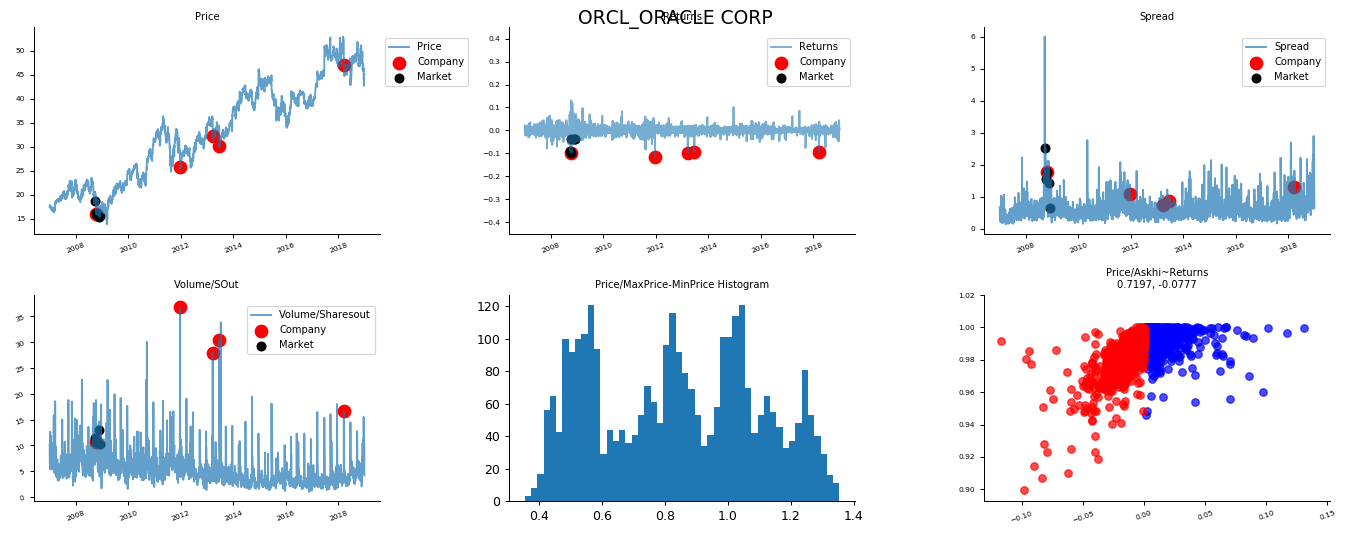

C:\PROGRA1\Anaconda3\lib\site-packages\ipykernel\__main__.py:64: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
C:\PROGRA1\Anaconda3\lib\site-packages\ipykernel\__main__.py:108: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
C:\PROGRA1\Anaconda3\lib\site-packages\ipykernel\__main__.py:151: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
C:\PROGRA1\Anaconda3\lib\site-packages\ipykernel\__main__.py:197: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


In [34]:
#symbol = 'ADM_ARCHER DANIELS MIDLAND CO'

#sup_title_font =15
sup_title_font =8
sub_title_font =8
legend_font =8
axis_font = 6
tick_rotation = 20
black_dot = 2
red_dot = 5

### matrix of subplots
n_cols = 3
n_rows = 2
n_plots = n_cols*n_rows
temp_matrix = np.array(range(n_plots)).reshape(n_rows,n_cols)

for symbol in df_returns.columns:
    ### initiate plot
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(15,6))

    #######
    ###-----------Subplot 1: Timeseries Price-----#################
    ##########
    ###########

    dot_labels_price = ['Price', 'Company', 'Market']
    temp_list_of_axis_price = []

    ### company prices, worst 5 dates with worst returns
    temp_worst_prices = worst_days_prices[symbol]
    ### comapny returns, worst 5 systemic dates with worst returns
    temp_worst_prices_sp = worst_days_prices_sp[symbol]


    ### Company Timeseries            
    wt = ax[0, 0].plot(dates, df_price[symbol].values, label='Daily Price'.format(symbol), alpha=0.7)            

    ### PLOT: 5 worst company dates
    wc = ax[0, 0].scatter(temp_worst_prices.index, temp_worst_prices.values, 
               color='red', 
               linewidths=red_dot, 
               edgecolor='red') 
               #label='Worst Company Trading')
    ### PLOT: Returns on 5 worst systemic dates 
    wm = ax[0,0].scatter(temp_worst_prices_sp.index, temp_worst_prices_sp.values, 
               color='black', 
               linewidths=black_dot, 
               edgecolor='black') 
               #label='Worst Market Trading Days')  

    ax[0,0].spines['top'].set_visible(False)
    ax[0,0].spines['right'].set_visible(False)
    #ax[0,0].set_title('Price', fontsize=sup_title_font) 
    #ax[k,l].set_xlabel(fontsize=x_axis_font)
    ax[0,0].tick_params(axis="x", labelsize=axis_font, rotation=tick_rotation)
    ax[0,0].tick_params(axis="y", labelsize=axis_font)
    #ax[k,l].set_ylim([-0.45, 0.45])            
    temp_list_of_axis_price.append([wc, wm, wt])
    #ax[0,0].set_title('Price', fontsize=sup_title_font)
    ax[0,0].legend(temp_list_of_axis_price, labels=dot_labels_price, 
               #title='Worst Trading Days', title_fontsize=25, 
               bbox_to_anchor=(1.0, 0.97), 
               prop={'size':legend_font})#, fontsize=sup_title_font)
    #ax[0.0].set_in_layout(False)





    ######
    ######------------Subplot2 : Timeseries Returns-----------------##################
    #####
    dot_labels_returns = ['Returns', 'Company', 'Market']
    temp_list_of_axis_returns = []

    ### company returns, worst 5 dates with worst returns
    temp_worst_returns = worst_days_returns[symbol]
    ### comapny returns, worst 5 systemic dates with worst returns
    temp_worst_returns_sp = worst_days_returns_sp[symbol]

    ### PLOT: 5 worst company dates
    wc_ret = ax[0,1].scatter(temp_worst_returns.index, temp_worst_returns.values, 
               color='red', 
               linewidths=red_dot, 
               edgecolor='red') 
    ### PLOT: Returns on 5 worst systemic dates 
    wm_ret = ax[0,1].scatter(temp_worst_returns_sp.index, temp_worst_returns_sp.values, 
               color='black', 
               linewidths=black_dot, 
               edgecolor='black')      
    ### Company Timeseries            
    wt_ret = ax[0,1].plot(dates, df_returns[symbol].values, label='Daily Returns'.format(symbol), alpha=0.6)


    ax[0,1].spines['top'].set_visible(False)
    ax[0,1].spines['right'].set_visible(False)
    #ax[0,1].set_title('Returns', fontsize=sup_title_font, pad=1.5) 
    #ax[k,l].set_xlabel(fontsize=x_axis_font)
    ax[0,1].tick_params(axis="x", labelsize=axis_font, rotation=tick_rotation)
    ax[0,1].tick_params(axis="y", labelsize=axis_font)
    ax[0,1].set_ylim([-0.45, 0.45])            
    temp_list_of_axis_returns.append([wc_ret, wm_ret, wt_ret])
    #ax[0,1].set_title('Returns', fontsize=sup_title_font)
    ax[0,1].legend(temp_list_of_axis_returns, labels=dot_labels_returns, 
               #title='Worst Trading Days', title_fontsize=25, 
               bbox_to_anchor=(1.0, 0.97), 
               prop={'size':legend_font})#, fontsize=sup_title_font)
    #ax[0.0].set_in_layout(False)



    #####
    ##########-----------Subplot3: Timeseries Spread--------#####
    ######
    dot_labels_spread = ['Spread', 'Company', 'Market']
    temp_list_of_axis_spread = []

    ### company prices, worst 5 dates with worst returns
    temp_worst_spread = worst_days_spread[symbol]
    ### comapny returns, worst 5 systemic dates with worst returns
    temp_worst_spread_sp = worst_days_spread_sp[symbol]

    ### Company Timeseries            
    wt_spread = ax[0, 2].plot(dates, df_spread[symbol].values, label='Daily Spread'.format(symbol), alpha=0.7)            

    ### PLOT: 5 worst company dates
    wc_spread = ax[0, 2].scatter(temp_worst_spread.index, temp_worst_spread.values, 
               color='red', 
               linewidths=red_dot, 
               edgecolor='red') 
               #label='Worst Company Trading')
    ### PLOT: Returns on 5 worst systemic dates 
    wm_spread = ax[0,2].scatter(temp_worst_spread_sp.index, temp_worst_spread_sp.values, 
               color='black', 
               linewidths=black_dot, 
               edgecolor='black') 
               #label='Worst Market Trading Days')            

    ax[0,2].spines['top'].set_visible(False)
    ax[0,2].spines['right'].set_visible(False)
    #ax[0,2].set_title('Spread', fontsize=sup_title_font) 
    #ax[k,l].set_xlabel(fontsize=x_axis_font)
    ax[0,2].tick_params(axis="x", labelsize=axis_font, rotation=tick_rotation)
    ax[0,2].tick_params(axis="y", labelsize=axis_font)           
    temp_list_of_axis_spread.append([wc_spread, wm_spread, wt_spread]) 
    #ax[0,2].set_title('Spread', fontsize=sup_title_font)
    ax[0,2].legend(temp_list_of_axis_spread, labels=dot_labels_spread, 
               #title='Worst Trading Days', title_fontsize=25, 
               bbox_to_anchor=(1.0, 0.97), 
               prop={'size':legend_font})#, fontsize=sup_title_font)




    ######
    ###---------Subplot4: Timeseries Volume/Sharesout-----#####
    ########


    dot_labels_vs = ['Volume/Sharesout', 'Company', 'Market']
    temp_list_of_axis_vs = []

    ### company prices, worst 5 dates with worst returns
    temp_worst_volume_sharesout = worst_days_volume_sharesout[symbol]
    ### comapny returns, worst 5 systemic dates with worst returns
    temp_worst_volume_sharesout_sp = worst_days_volume_sharesout_sp[symbol]

    ### Company Timeseries            
    wt_vs = ax[1,0].plot(dates, df_volume_sharesout[symbol].values, label='Daily Vol/SOut'.format(symbol), alpha=0.7)            

    ### PLOT: 5 worst company dates
    wc_vs = ax[1,0].scatter(temp_worst_volume_sharesout.index, temp_worst_volume_sharesout.values, 
               color='red', 
               linewidths=red_dot, 
               edgecolor='red') 
               #label='Worst Company Trading')
    ### PLOT: Returns on 5 worst systemic dates 
    wm_vs = ax[1,0].scatter(temp_worst_volume_sharesout_sp.index, temp_worst_volume_sharesout_sp.values, 
               color='black', 
               linewidths=black_dot, 
               edgecolor='black') 
               #label='Worst Market Trading Days')            

    ax[1,0].spines['top'].set_visible(False)
    ax[1,0].spines['right'].set_visible(False)
    #ax[1,1].set_title('Volume/Sharesout', fontsize=sub_title_font) 
    #ax[k,l].set_xlabel(fontsize=x_axis_font)
    ax[1,0].tick_params(axis="x", labelsize=axis_font, rotation=tick_rotation)
    ax[1,0].tick_params(axis="y", labelsize=axis_font, rotation=tick_rotation)         
    temp_list_of_axis_vs.append([wc_vs, wm_vs, wt_vs])
    #ax[1,0].set_title('Volume/SOut', fontsize=sup_title_font)

    ax[1,0].legend(temp_list_of_axis_vs, labels=dot_labels_vs, 
               #title='Worst Trading Days', title_fontsize=25, 
               bbox_to_anchor=(1.0, 0.97), 
               prop={'size':legend_font})#, fontsize=sup_title_font)


    
    
    ##########
    ########-----------Subplot5: Histogram Price/minmaxprice--------#########
    ###########
    ### plot the histogram
#     gs = ax[1, 1].get_gridspec()
#     for axs in ax[1:, 1]:
#         axs.remove()
#     axbig = fig.add_subplot(gs[1:, 1], figsize=(2,3))
#     axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.1),
#                    xycoords='axes fraction', va='center')    
    temp_scaled_price = scaled_price_dic[symbol]
    temp_std = round(np.std(temp_scaled_price), 2)
    ax[1,1].spines['top'].set_visible(False)
    ax[1,1].spines['right'].set_visible(False)
    ax[1,1].hist(temp_scaled_price, bins=50)
    ax[1,1].set_title('Price/MaxPrice-MinPrice Histogram', fontsize=sup_title_font)
#     hist=plt.hist(temp_scaled_price, bins=50)
#     boxplot = ax[1,1].boxplot(temp_scaled_price)

#     divider = make_axes_locatable(ax[1,1])
#     cax = divider.append_axes("bottom",size="5%",pad=0.7)
    #cbar=fig.colorbar(boxplot,cax=cax,orientation=u'horizontal'
    

    ##########
    ########-----------Subplot6: Correlation Price/Askhi--------#########
    ###########
    ### plot the histogram
    temp_corr = corrs[symbol]
    temp_color = []
    for value in temp_corr:
        if value <= 0.4:
            temp_color.append('blue')
        elif value <= 0.7: 
            temp_color.append('yellow')
        else:
            temp_color.append('red')

    ### PLOT: Low Correlations 
    ax[1,2].scatter(high_returns[symbol], pa_high_returns[symbol], 
               color=temp_color[0], alpha=0.7)             
    ### PLOT: High Correlations 
    ax[1,2].scatter(low_returns[symbol], pa_low_returns[symbol], 
               color=temp_color[1], alpha=0.7)             

    ax[1,2].spines['top'].set_visible(False)
    ax[1,2].spines['right'].set_visible(False)
    ax[1,2].set_title('Price/Askhi~Returns\n{}, {}'.format(round(corrs[symbol][1], 4), round(corrs[symbol][0], 4)), fontsize=sub_title_font) 
    #ax[k,l].set_xlabel(fontsize=x_axis_font)
    ax[1,2].tick_params(axis="x", labelsize=axis_font, rotation=tick_rotation)
    ax[1,2].tick_params(axis="y", labelsize=axis_font)


    ### FINAL TOUCHES
    fig.subplots_adjust(hspace=0.4, wspace=0.0)
    fig.suptitle('{}'.format(symbol), fontsize=15)
#     plt.tight_layout(pad=0.2, w_pad=0.5, h_pad=5.0)    
    plt.tight_layout()

    plt.show()
    plt.savefig('plots\\viz_portfolio2\\{}_viz.png'.format(symbol), dpi=220)     
    break

In [ ]:
# #sup_title_font =15
# sub_title_font =8
# legend_font =8
# axis_font = 6
# tick_rotation = 20
# black_dot = 2
# red_dot = 5

# ### matrix of subplots
# n_cols = 7
# n_rows = 2
# n_plots = n_cols*n_rows
# nloops = int(np.floor(388/n_plots))
# temp_matrix = np.array(range(n_plots)).reshape(n_rows,n_cols)

# fig, ax = plt.subplots(n_cols,n_rows,figsize=(17,12))



# plt.tight_layout()

# 3x2 Subplots

In [36]:
small_symbol_list= ['IP_INTERNATIONAL PAPER CO', 'NFLX_NETFLIX INC']

<IPython.core.display.Javascript object>


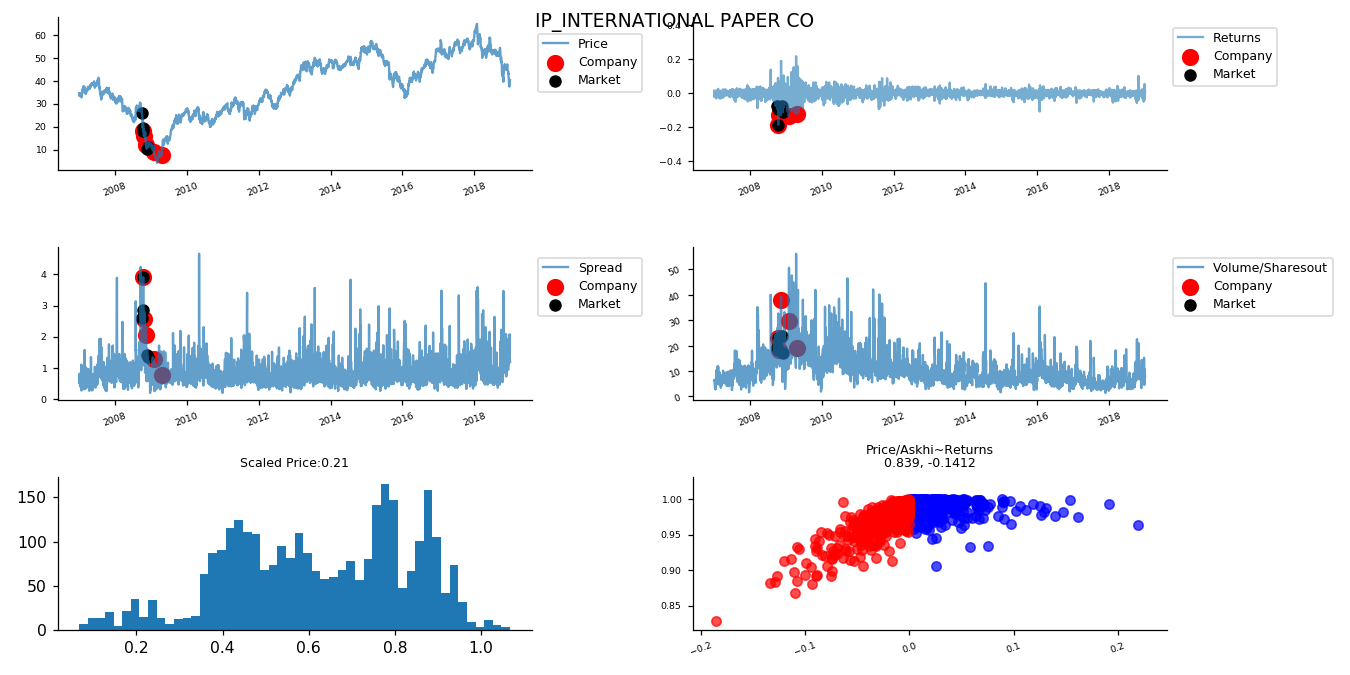

C:\PROGRA1\Anaconda3\lib\site-packages\ipykernel\__main__.py:64: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
C:\PROGRA1\Anaconda3\lib\site-packages\ipykernel\__main__.py:108: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
C:\PROGRA1\Anaconda3\lib\site-packages\ipykernel\__main__.py:149: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
C:\PROGRA1\Anaconda3\lib\site-packages\ipykernel\__main__.py:193: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


<IPython.core.display.Javascript object>


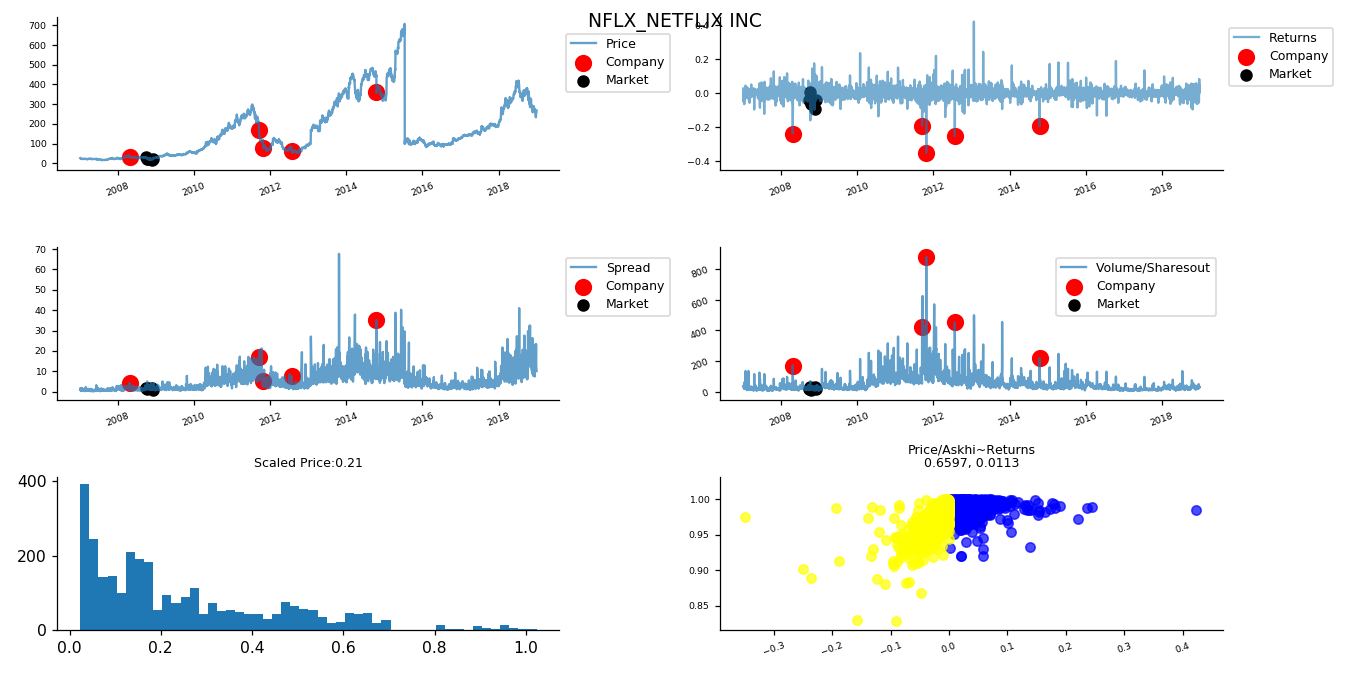

In [53]:
#symbol = 'ADM_ARCHER DANIELS MIDLAND CO'

#sup_title_font =15
sup_title_font =8
sub_title_font =8
legend_font =8
axis_font = 6
tick_rotation = 20
black_dot = 2
red_dot = 5

### matrix of subplots
n_rows = 3
n_cols = 2
n_plots = n_cols*n_rows
temp_matrix = np.array(range(n_plots)).reshape(n_rows,n_cols)

for symbol in small_symbol_list:
    ### initiate plot
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(12,6))

    #######
    ###-----------Subplot 1: Timeseries Price-----#################
    ##########
    ###########

    dot_labels_price = ['Price', 'Company', 'Market']
    temp_list_of_axis_price = []

    ### company prices, worst 5 dates with worst returns
    temp_worst_prices = worst_days_prices[symbol]
    ### comapny returns, worst 5 systemic dates with worst returns
    temp_worst_prices_sp = worst_days_prices_sp[symbol]


    ### Company Timeseries            
    wt = ax[0, 0].plot(dates, df_price[symbol].values, label='Daily Price'.format(symbol), alpha=0.7)            

    ### PLOT: 5 worst company dates
    wc = ax[0, 0].scatter(temp_worst_prices.index, temp_worst_prices.values, 
               color='red', 
               linewidths=red_dot, 
               edgecolor='red') 
               #label='Worst Company Trading')
    ### PLOT: Returns on 5 worst systemic dates 
    wm = ax[0,0].scatter(temp_worst_prices_sp.index, temp_worst_prices_sp.values, 
               color='black', 
               linewidths=black_dot, 
               edgecolor='black') 
               #label='Worst Market Trading Days')  

    ax[0,0].spines['top'].set_visible(False)
    ax[0,0].spines['right'].set_visible(False)
    #ax[0,0].set_title('Price', fontsize=sup_title_font) 
    #ax[k,l].set_xlabel(fontsize=x_axis_font)
    ax[0,0].tick_params(axis="x", labelsize=axis_font, rotation=tick_rotation)
    ax[0,0].tick_params(axis="y", labelsize=axis_font)
    #ax[k,l].set_ylim([-0.45, 0.45])            
    temp_list_of_axis_price.append([wc, wm, wt])

    ax[0,0].legend(temp_list_of_axis_price, labels=dot_labels_price, 
               #title='Worst Trading Days', title_fontsize=25, 
               bbox_to_anchor=(1.0, 0.93), 
               prop={'size':legend_font})#, fontsize=sup_title_font)
    #ax[0.0].set_in_layout(False)





    ######
    ######------------Subplot2 : Timeseries Returns-----------------##################
    #####
    dot_labels_returns = ['Returns', 'Company', 'Market']
    temp_list_of_axis_returns = []

    ### company returns, worst 5 dates with worst returns
    temp_worst_returns = worst_days_returns[symbol]
    ### comapny returns, worst 5 systemic dates with worst returns
    temp_worst_returns_sp = worst_days_returns_sp[symbol]

    ### PLOT: 5 worst company dates
    wc_ret = ax[0,1].scatter(temp_worst_returns.index, temp_worst_returns.values, 
               color='red', 
               linewidths=red_dot, 
               edgecolor='red') 
    ### PLOT: Returns on 5 worst systemic dates 
    wm_ret = ax[0,1].scatter(temp_worst_returns_sp.index, temp_worst_returns_sp.values, 
               color='black', 
               linewidths=black_dot, 
               edgecolor='black')      
    ### Company Timeseries            
    wt_ret = ax[0,1].plot(dates, df_returns[symbol].values, label='Daily Returns'.format(symbol), alpha=0.6)


    ax[0,1].spines['top'].set_visible(False)
    ax[0,1].spines['right'].set_visible(False)
    #ax[0,1].set_title('Returns', fontsize=sup_title_font, pad=1.5) 
    #ax[k,l].set_xlabel(fontsize=x_axis_font)
    ax[0,1].tick_params(axis="x", labelsize=axis_font, rotation=tick_rotation)
    ax[0,1].tick_params(axis="y", labelsize=axis_font)
    ax[0,1].set_ylim([-0.45, 0.45])            
    temp_list_of_axis_returns.append([wc_ret, wm_ret, wt_ret])

    ax[0,1].legend(temp_list_of_axis_returns, labels=dot_labels_returns, 
               #title='Worst Trading Days', title_fontsize=25, 
               bbox_to_anchor=(1.0, 0.97), 
               prop={'size':legend_font})#, fontsize=sup_title_font)
    #ax[0.0].set_in_layout(False)



    #####
    ##########-----------Subplot3: Timeseries Spread--------#####
    ######
    dot_labels_spread = ['Spread', 'Company', 'Market']
    temp_list_of_axis_spread = []

    ### company prices, worst 5 dates with worst returns
    temp_worst_spread = worst_days_spread[symbol]
    ### comapny returns, worst 5 systemic dates with worst returns
    temp_worst_spread_sp = worst_days_spread_sp[symbol]

    ### Company Timeseries            
    wt_spread = ax[1, 0].plot(dates, df_spread[symbol].values, label='Daily Spread'.format(symbol), alpha=0.7)            

    ### PLOT: 5 worst company dates
    wc_spread = ax[1, 0].scatter(temp_worst_spread.index, temp_worst_spread.values, 
               color='red', 
               linewidths=red_dot, 
               edgecolor='red') 
               #label='Worst Company Trading')
    ### PLOT: Returns on 5 worst systemic dates 
    wm_spread = ax[1,0].scatter(temp_worst_spread_sp.index, temp_worst_spread_sp.values, 
               color='black', 
               linewidths=black_dot, 
               edgecolor='black') 
               #label='Worst Market Trading Days')            

    ax[1,0].spines['top'].set_visible(False)
    ax[1,0].spines['right'].set_visible(False)
    ax[1,0].tick_params(axis="x", labelsize=axis_font, rotation=tick_rotation)
    ax[1,0].tick_params(axis="y", labelsize=axis_font)           
    temp_list_of_axis_spread.append([wc_spread, wm_spread, wt_spread]) 

    ax[1,0].legend(temp_list_of_axis_spread, labels=dot_labels_spread, 
               #title='Worst Trading Days', title_fontsize=25, 
               bbox_to_anchor=(1.0, 0.97), 
               prop={'size':legend_font})#, fontsize=sup_title_font)




    ######
    ###---------Subplot4: Timeseries Volume/Sharesout-----#####
    ########


    dot_labels_vs = ['Volume/Sharesout', 'Company', 'Market']
    temp_list_of_axis_vs = []

    ### company prices, worst 5 dates with worst returns
    temp_worst_volume_sharesout = worst_days_volume_sharesout[symbol]
    ### comapny returns, worst 5 systemic dates with worst returns
    temp_worst_volume_sharesout_sp = worst_days_volume_sharesout_sp[symbol]

    ### Company Timeseries            
    wt_vs = ax[1,1].plot(dates, df_volume_sharesout[symbol].values, label='Daily Vol/SOut'.format(symbol), alpha=0.7)            

    ### PLOT: 5 worst company dates
    wc_vs = ax[1,1].scatter(temp_worst_volume_sharesout.index, temp_worst_volume_sharesout.values, 
               color='red', 
               linewidths=red_dot, 
               edgecolor='red') 
               #label='Worst Company Trading')
    ### PLOT: Returns on 5 worst systemic dates 
    wm_vs = ax[1,1].scatter(temp_worst_volume_sharesout_sp.index, temp_worst_volume_sharesout_sp.values, 
               color='black', 
               linewidths=black_dot, 
               edgecolor='black') 
               #label='Worst Market Trading Days')            

    ax[1,1].spines['top'].set_visible(False)
    ax[1,1].spines['right'].set_visible(False)
    ax[1,1].tick_params(axis="x", labelsize=axis_font, rotation=tick_rotation)
    ax[1,1].tick_params(axis="y", labelsize=axis_font, rotation=tick_rotation)         
    temp_list_of_axis_vs.append([wc_vs, wm_vs, wt_vs])


    ax[1,1].legend(temp_list_of_axis_vs, labels=dot_labels_vs, 
               #title='Worst Trading Days', title_fontsize=25, 
               bbox_to_anchor=(1.0, 0.97), 
               prop={'size':legend_font})#, fontsize=sup_title_font)


    
    
    ##########
    ########-----------Subplot5: Histogram Price/minmaxprice--------#########
    ###########
    ### plot the histogram  
    temp_scaled_price = scaled_price_dic[symbol]
    temp_std = round(np.std(temp_scaled_price), 2)
    ax[2,0].spines['top'].set_visible(False)
    ax[2,0].spines['right'].set_visible(False)
    ax[2,0].hist(temp_scaled_price, bins=50)
    ax[2,0].set_title('Scaled Price:{}'.format(temp_std), fontsize=sup_title_font)

    

    ##########
    ########-----------Subplot6: Correlation Price/Askhi--------#########
    ###########
    ### plot the histogram
    temp_corr = corrs[symbol]
    temp_color = []
    for value in temp_corr:
        if value <= 0.4:
            temp_color.append('blue')
        elif value <= 0.7: 
            temp_color.append('yellow')
        else:
            temp_color.append('red')

    ### PLOT: Low Correlations 
    ax[2,1].scatter(high_returns[symbol], pa_high_returns[symbol], 
               color=temp_color[0], alpha=0.7)             
    ### PLOT: High Correlations 
    ax[2,1].scatter(low_returns[symbol], pa_low_returns[symbol], 
               color=temp_color[1], alpha=0.7)             

    ax[2,1].spines['top'].set_visible(False)
    ax[2,1].spines['right'].set_visible(False)
    ax[2,1].set_title('Price/Askhi~Returns\n{}, {}'.format(round(corrs[symbol][1], 4), round(corrs[symbol][0], 4)), fontsize=sub_title_font) 
    #ax[k,l].set_xlabel(fontsize=x_axis_font)
    ax[2,1].tick_params(axis="x", labelsize=axis_font, rotation=tick_rotation)
    ax[2,1].tick_params(axis="y", labelsize=axis_font)


    ### FINAL TOUCHES
    fig.subplots_adjust(hspace=0.4, wspace=0.2)
    fig.suptitle('{}'.format(symbol), fontsize=12)
    #fig.subplots_adjust(top=2.5)
    #plt.tight_layout(pad=0.2, w_pad=0.5, h_pad=5.0)    
    plt.tight_layout()

    plt.show()
    plt.savefig('plots\\viz_portfolio_temp\\{}_viz.png'.format(symbol), dpi=220)     
